<a href="https://colab.research.google.com/github/ymciss0/Applied_Machine_Learning/blob/dev/AML_HW3_YC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AML Homework 3

### Author: Yelene Cisse
### Date: 11/18/2025
### Data: https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
### Purpose:  

Predict next token using Transformer architecture.

## Set up
Define useful functions. Import necessary libraries and dataset.

#### Imports

In [1]:
!pip install xlsxwriter
!pip install google

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from collections import Counter
from torch.cuda.amp import autocast, GradScaler

from sklearn.model_selection import train_test_split
import requests
from tokenizers import ByteLevelBPETokenizer

from seaborn import heatmap

import openpyxl
import xlsxwriter
from google.colab import drive
import os

# Set random seed
torch.manual_seed(62)
np.random.seed(62)

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Class definitions

In [3]:
# The code below was adapted from the "L8_Transformer.ipynb" example
class SelfAttention(nn.Module):
    """Self-attention with causal masking"""
    def __init__(self, d_model):
        super().__init__()
        self.d_model = d_model
        self.W_q = nn.Linear(d_model, d_model, bias=False)
        self.W_k = nn.Linear(d_model, d_model, bias=False)
        self.W_v = nn.Linear(d_model, d_model, bias=False)

    def forward(self, x):
        batch_size, seq_len, d_model = x.shape

        Q = self.W_q(x)
        K = self.W_k(x)
        V = self.W_v(x)

        scores = Q @ K.transpose(-2, -1) / (d_model ** 0.5)

        # Causal mask
        mask = torch.tril(torch.ones(seq_len, seq_len)).to(x.device)
        scores = scores.masked_fill(mask == 0, float('-inf'))

        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = torch.nan_to_num(attn_weights, 0.0)

        output = attn_weights @ V
        return output, attn_weights


class FeedForward(nn.Module):
    """Two-layer MLP"""
    def __init__(self, d_model, d_ff):
        super().__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        return self.fc2(F.relu(self.fc1(x)))


class TransformerBlock(nn.Module):
    """One transformer block: Attention + FFN + Residuals"""
    def __init__(self, d_model, d_ff):
        super().__init__()

        # Add RSNorm layers
        self.rmsn1 = nn.RMSNorm(d_model)
        self.rmsn2 = nn.RMSNorm(d_model)

        self.attention = SelfAttention(d_model) # or nn.MultiheadAttention(embed_dim = d_model, num_heads = 1, dropout = 0.01, bias = True, batch_first = True ) ?
        self.ffn = FeedForward(d_model, d_ff)

    def forward(self, x):
        norm_feat1 = self.rmsn1(x)
        attn_out, attn_weights = self.attention(norm_feat1)
        x = x + attn_out  # Residual

        norm_feat2 = self.rmsn2(x)
        ffn_out = self.ffn(norm_feat2)
        x = x + ffn_out  # Residual

        return x, attn_weights


class TinyTransformer(nn.Module):
    """Complete transformer model"""
    def __init__(self, vocab_size, d_model, n_layers, d_ff, max_seq_len=128):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = nn.Parameter(torch.randn(1, max_seq_len, d_model) * 0.02)

        self.blocks = nn.ModuleList([
            TransformerBlock(d_model, d_ff) for _ in range(n_layers)
        ])

        self.output_layer = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        seq_len = x.shape[1]
        x = self.token_embedding(x) + self.pos_encoding[:, :seq_len, :]

        all_attn = []
        for block in self.blocks:
            x, attn = block(x)
            all_attn.append(attn)

        logits = self.output_layer(x)
        return logits, all_attn

#### Function definitions

In [4]:
# Function to create overlapping sequences of tokens
def SeqFormat(tokens, n, shift):
  token_chunks = {}
  counter = 1
  for i in range(0, len(tokens) - n+1, shift):
    token_chunks[counter] = tokens[i:i+n]
    counter+=1

  return token_chunks

In [5]:
# Visualize training progress - from "L8_Transformer.ipynb" example
def plot_train_loss_acc(train_losses, train_accs):
  plt.close()
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

  ax1.plot(train_losses, linewidth=2, color='steelblue')
  ax1.set_xlabel('Epoch', fontsize=12, fontweight='bold')
  ax1.set_ylabel('Loss', fontsize=12, fontweight='bold')
  ax1.set_title('Training Loss', fontsize=14, fontweight='bold')
  ax1.grid(alpha=0.3)

  ax2.plot(train_accs, linewidth=2, color='seagreen')
  ax2.set_xlabel('Epoch', fontsize=12, fontweight='bold')
  ax2.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
  ax2.set_title('Training Accuracy', fontsize=14, fontweight='bold')
  ax2.set_ylim([0, 1])
  ax2.grid(alpha=0.3)

  plt.tight_layout()
  plt.close()
  return fig

# Training and validation loss, train and perplexity curves over epochs

def plot_loss_validation_curve(epochs, train_loss, test_loss, model_version='', ylabel='Loss',xlabel='Epochs'):
    plt.close()
    fig, ax = plt.subplots(figsize=(10, 8))

    # Plot learning curve
    plt.plot(epochs, train_loss, label="Training loss", marker='o')
    plt.plot(epochs, test_loss, label="Test loss", marker='o')
    plt.title("Validation Curve: " + ylabel + " over " + xlabel)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc="best")
    plt.grid(True)
    plt.close()
    return fig


def plot_acc_validation_curve(epochs, train_acc, test_acc, model_version='', ylabel='Accuracy',xlabel='Epochs'):
    plt.close()
    fig, ax = plt.subplots(figsize=(10, 8))

    # Plot learning curve
    plt.plot(epochs, train_acc, label="Training accuracy", marker='o')
    plt.plot(epochs, test_acc, label="Test accuracy", marker='o')
    plt.title("Validation Curve: " + ylabel + " over " + xlabel)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc="best")
    plt.grid(True)
    plt.close()
    return fig


def plot_ppl_validation_curve(epochs, train_ppl, test_ppl, model_version='', ylabel='Perplexity',xlabel='Epochs'):
    plt.close()
    fig, ax = plt.subplots(figsize=(14, 12))

    # Plot learning curve
    plt.plot(epochs, train_ppl, label="Training perplexity", marker='o')
    plt.plot(epochs, test_ppl, label="Test perplexity", marker='o')
    plt.title("Validation Curve: " + ylabel + " over " + xlabel)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc="best")
    plt.grid(True)
    plt.close()
    return fig

# Visualize learning rates

def plot_lr_validation_curve(epochs, curr_lr, new_lr, model_version='', ylabel='Learning rate',xlabel='Epochs'):
    plt.close()
    fig, ax = plt.subplots(figsize=(14, 12))

    # Plot learning curve
    plt.plot(epochs, curr_lr, label="Current learning rate", marker='o')
    plt.plot(epochs, new_lr, label="New learning rate", marker='o')
    plt.title("Validation Curve: " + ylabel + " over " + xlabel)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.yscale('log')
    plt.legend(loc="best")
    plt.grid(True)
    plt.close()
    return fig

def plot_attention_matrix(test_attns, n, title, color="Blues", annotation=False):
    sample = {}
    plots = {}

    for _ in range(n):
        test_epoch = random.randint(0, len(test_attns) - 1)
        sample[test_epoch] = test_attns[test_epoch]

    for epoch, attn in sample.items():
        plt.close()
        fig, ax = plt.subplots(figsize=(10, 8))
        attn_matrix = attn[-1].cpu().numpy()

        im = ax.imshow(attn_matrix, cmap=color, aspect='auto', vmin=0, vmax=1)
        plt.colorbar(im, ax=ax)

        ax.set_xlabel("Key Position (attending to)", fontsize=12)
        ax.set_ylabel("Query Position (attending from)", fontsize=12)
        ax.set_title(f"{title} Test epoch {epoch + 1}", fontsize=14)

        plots[epoch] = fig
        plt.close()

    return plots

#### Model Set up

In [6]:
# Set up data and model parameters
params = {
    "vocab_size": 500, # For tokenization
    "fixed_len_seq": 25, # For sequence formatting

    # For model training
    "embedding_dim": 128,
    "n_layers": 2,
    "d_ff": 512,
    "learning_rate": 0.001, # 0.001
    "n_epochs": 60,
    "batch_size": 4096
}

# Save model parameters
df_params = pd.DataFrame([params])

# Define for results save
path = "/content/drive/MyDrive/AML_HMW3_results/"
os.makedirs(path, exist_ok=True)
model_version = "_v5"
result_filename = "Results_model_" + model_version + ".xlsx"

# For model results export
results_summary = {}
results_summary[f"model{model_version}_parameters"] = df_params

## Data preparation

In [7]:
# Load Shakespeare dataset

url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"

response = requests.get(url)

corpus = response.text

# Save to local file for token training
with open("/content/shakespeare_input.txt", "w", encoding="utf-8") as f:
    f.write(corpus)

In [8]:
# Create tokens
tokenizer = ByteLevelBPETokenizer()
tokenizer.train(["shakespeare_input.txt"], vocab_size=params["vocab_size"], min_frequency=2)

encoded = tokenizer.encode(corpus)
encoded_ids = encoded.ids
print(encoded_ids[0])
print(len(encoded))

37
581009


In [9]:
# Split the tokenized text into overlapping fixed-length sequences
sequences = SeqFormat(encoded_ids, params["fixed_len_seq"], 1)
print(len(sequences))

# Create list of sequences for processing
token_list = [i for i in sequences.values()]
print(len(token_list))

580985
580985


In [10]:
# Create the Input and target datasets
X_data = token_list[:-1]
Y_data = token_list[1:]

# Split the data into train and test sets
X_train, X_test , Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state = 62, shuffle=True)

for data in [X_train, X_test, Y_train, Y_test ]:
    print('Data shape: ', len(data))

max_seq_len = max(len(seq) for seq in X_train)
print(max_seq_len)

# Change to tensors for model training
X_train_padded = torch.tensor([x + [0]*(max_seq_len - len(x)) for x in X_train])
Y_train_tensor = torch.tensor(Y_train)

X_test_padded = torch.tensor([x + [0]*(max_seq_len - len(x)) for x in X_test])
Y_test_tensor = torch.tensor(Y_test)

Data shape:  464787
Data shape:  116197
Data shape:  464787
Data shape:  116197
25


## Model training

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    print(f"✓ Using GPU: {torch.cuda.get_device_name(0)}")
    print(f"  Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("⚠ No GPU found, using CPU")

✓ Using GPU: Tesla T4
  Memory: 15.83 GB


In [12]:
# Create model set up
model = TinyTransformer(params["vocab_size"], params["embedding_dim"], params["n_layers"], params["d_ff"], max_seq_len).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=params["learning_rate"] , weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=50)

if device.type == 'cuda':
  scaler = torch.amp.GradScaler('cuda')
else:
  scaler = GradScaler()


print("\n" + "="*70)
print("MODEL ARCHITECTURE")
print("="*70)
print(f"Device: {device}")
print(f"Embedding dim: {params["embedding_dim"]}")
print(f"Layers: {params["n_layers"]}")
print(f"FFN hidden: {params["d_ff"]}")
print(f"Batch size: {params["batch_size"]}")
print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Epochs: {params["n_epochs"]}")

print("\n" + "="*70)
print("TRAINING")
print("="*70)


MODEL ARCHITECTURE
Device: cuda
Embedding dim: 128
Layers: 2
FFN hidden: 512
Batch size: 4096
Parameters: 493,940
Epochs: 60

TRAINING


In [13]:
print("\nDetailed Parameter Count:")
print("="*50)
for name, param in model.named_parameters():
    print(f"{name:40s} {param.numel():>10,} parameters")
print("="*50)
print(f"{'TOTAL':40s} {sum(p.numel() for p in model.parameters()):>10,}")



Detailed Parameter Count:
pos_encoding                                  3,200 parameters
token_embedding.weight                       64,000 parameters
blocks.0.rmsn1.weight                           128 parameters
blocks.0.rmsn2.weight                           128 parameters
blocks.0.attention.W_q.weight                16,384 parameters
blocks.0.attention.W_k.weight                16,384 parameters
blocks.0.attention.W_v.weight                16,384 parameters
blocks.0.ffn.fc1.weight                      65,536 parameters
blocks.0.ffn.fc1.bias                           512 parameters
blocks.0.ffn.fc2.weight                      65,536 parameters
blocks.0.ffn.fc2.bias                           128 parameters
blocks.1.rmsn1.weight                           128 parameters
blocks.1.rmsn2.weight                           128 parameters
blocks.1.attention.W_q.weight                16,384 parameters
blocks.1.attention.W_k.weight                16,384 parameters
blocks.1.attention.W_v.weigh

In [14]:
%env CUDA_LAUNCH_BLOCKING=1

env: CUDA_LAUNCH_BLOCKING=1


In [15]:
# Train epochs
train_losses, test_losses = [], []
train_accs, test_accs = [], []
train_ppls, test_ppls = [], []


train_lrs = pd.DataFrame(columns=["epoch", "curr_lr", "new_lr", "loss", "ppl", "acc"])

test_attns = []

best_ppl = float('inf')
best_epoch = 0

n_samples = len(X_train_padded)

# Move data to GPU
X_train_padded = X_train_padded.to(device)
Y_train_tensor = Y_train_tensor.to(device)
X_test_padded = X_test_padded.to(device)
Y_test_tensor = Y_test_tensor.to(device)


for epoch in range(params["n_epochs"]):

  # Model training
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    n_batches = 0

    # indices = torch.randperm(n_samples, device=device)
    indices = torch.randperm(n_samples, device='cpu').to(device)

    for i in range(0, n_samples, params["batch_size"]):
        batch_idx = indices[i:min(i+params["batch_size"], n_samples)]
        batch_X = X_train_padded[batch_idx]
        batch_Y = Y_train_tensor[batch_idx]

        optimizer.zero_grad()

        with autocast():
            logits, all_attn = model(batch_X)

            # Reshape for loss calculation
            logits_flat = logits.reshape(-1, params["vocab_size"])
            targets_flat = batch_Y.reshape(-1)

            loss = criterion(logits_flat, targets_flat)

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()


        # Calculate accuracy
        pred_tokens = torch.argmax(logits, dim=-1)
        acc = (pred_tokens == batch_Y).float().mean().item()


        epoch_loss += loss.item()
        epoch_acc += acc
        n_batches += 1

    avg_train_loss = epoch_loss / n_batches
    avg_train_acc = epoch_acc / n_batches

    # Calculate perplexity
    avg_train_ppl = np.exp(avg_train_loss)


    train_losses.append(avg_train_loss)
    train_accs.append(avg_train_acc)
    train_ppls.append(avg_train_ppl)

    curr_lr = optimizer.param_groups[0]['lr']
    scheduler.step(avg_train_loss)
    new_lr = optimizer.param_groups[0]['lr']
    train_lrs.loc[len(train_lrs.index)] = [epoch+1, curr_lr, new_lr, avg_train_loss, avg_train_ppl, avg_train_acc]
    if new_lr != curr_lr:
        print(f"    → LR reduced: {curr_lr:.6f} → {new_lr:.6f}")

    del batch_X, batch_Y, logits
    torch.cuda.empty_cache()

    # Model testing
    model.eval()
    epoch_loss, epoch_acc, n_batches = 0.0, 0.0, 0

    with torch.no_grad():
        # Loop over test set in batches
        for i in range(0, len(X_test_padded), params["batch_size"]):
            batch_X = X_test_padded[i:i+params["batch_size"]]
            batch_Y = Y_test_tensor[i:i+params["batch_size"]]

            # Forward pass
            logits, all_attn = model(batch_X)

            # Reshape for loss calculation
            logits_flat = logits.reshape(-1, params["vocab_size"])
            targets_flat = batch_Y.reshape(-1)
            loss = criterion(logits_flat, targets_flat)

            # Calculate accuracy for this batch
            pred_tokens = torch.argmax(logits, dim=-1)
            acc = (pred_tokens == batch_Y).float().mean().item()

            # Accumulate batch loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc
            n_batches += 1

        # Average loss and accuracy over all batches
        test_loss = epoch_loss / n_batches
        test_acc = epoch_acc / n_batches
        test_ppl = np.exp(test_loss)  # Perplexity = exp(loss)

        # Save results for this epoch
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        test_ppls.append(test_ppl)

        # Save attention for heatmap plots
        # Only save the first sequence of the last batch to save memory
        attn_to_save = [attn_layer[0].cpu() for attn_layer in all_attn]
        test_attns.append(attn_to_save)

        # Track best perplexity
        if test_ppl < best_ppl:
            best_ppl = test_ppl
            best_epoch = epoch + 1

    torch.save(model.state_dict(), f"model_epoch_{epoch+1}.pt")

    if (epoch + 1) % 2 == 0:
        print(f"Epoch {epoch+1:4d}/{params["n_epochs"]} | Train Loss: {avg_train_loss:.4f} | Train Acc: {avg_train_acc:.2%} | Train Perplexity: {avg_train_ppl:.2f}")
        print(f"Epoch {epoch+1:4d}/{params["n_epochs"]} | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2%} | Test Perplexity: {test_ppl:.2f}")

print(f"\n✓ Training complete!")
print("Best perplexity: " + str(best_ppl) + " for epoch " + str(best_epoch))

# Clean up GPU memory
if device.type == 'cuda':
    torch.cuda.empty_cache()

/tmp/ipython-input-2609928831.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2609928831.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch    2/60 | Train Loss: 3.2696 | Train Acc: 24.12% | Train Perplexity: 26.30
Epoch    2/60 | Test Loss: 3.1283 | Test Acc: 26.94% | Test Perplexity: 22.83


/tmp/ipython-input-2609928831.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2609928831.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch    4/60 | Train Loss: 2.8671 | Train Acc: 31.91% | Train Perplexity: 17.59
Epoch    4/60 | Test Loss: 2.8101 | Test Acc: 33.00% | Test Perplexity: 16.61


/tmp/ipython-input-2609928831.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2609928831.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch    6/60 | Train Loss: 2.6907 | Train Acc: 35.21% | Train Perplexity: 14.74
Epoch    6/60 | Test Loss: 2.6640 | Test Acc: 35.71% | Test Perplexity: 14.35


/tmp/ipython-input-2609928831.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2609928831.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch    8/60 | Train Loss: 2.5923 | Train Acc: 36.91% | Train Perplexity: 13.36
Epoch    8/60 | Test Loss: 2.5809 | Test Acc: 37.12% | Test Perplexity: 13.21


/tmp/ipython-input-2609928831.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2609928831.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch   10/60 | Train Loss: 2.5249 | Train Acc: 38.10% | Train Perplexity: 12.49
Epoch   10/60 | Test Loss: 2.5178 | Test Acc: 38.22% | Test Perplexity: 12.40


/tmp/ipython-input-2609928831.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2609928831.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch   12/60 | Train Loss: 2.4740 | Train Acc: 38.98% | Train Perplexity: 11.87
Epoch   12/60 | Test Loss: 2.4708 | Test Acc: 39.07% | Test Perplexity: 11.83


/tmp/ipython-input-2609928831.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2609928831.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch   14/60 | Train Loss: 2.4322 | Train Acc: 39.72% | Train Perplexity: 11.38
Epoch   14/60 | Test Loss: 2.4369 | Test Acc: 39.65% | Test Perplexity: 11.44


/tmp/ipython-input-2609928831.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2609928831.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch   16/60 | Train Loss: 2.3974 | Train Acc: 40.33% | Train Perplexity: 10.99
Epoch   16/60 | Test Loss: 2.4032 | Test Acc: 40.22% | Test Perplexity: 11.06


/tmp/ipython-input-2609928831.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2609928831.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch   18/60 | Train Loss: 2.3675 | Train Acc: 40.86% | Train Perplexity: 10.67
Epoch   18/60 | Test Loss: 2.3803 | Test Acc: 40.62% | Test Perplexity: 10.81


/tmp/ipython-input-2609928831.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2609928831.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch   20/60 | Train Loss: 2.3425 | Train Acc: 41.31% | Train Perplexity: 10.41
Epoch   20/60 | Test Loss: 2.3488 | Test Acc: 41.25% | Test Perplexity: 10.47


/tmp/ipython-input-2609928831.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2609928831.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch   22/60 | Train Loss: 2.3185 | Train Acc: 41.74% | Train Perplexity: 10.16
Epoch   22/60 | Test Loss: 2.3305 | Test Acc: 41.55% | Test Perplexity: 10.28


/tmp/ipython-input-2609928831.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2609928831.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch   24/60 | Train Loss: 2.2970 | Train Acc: 42.15% | Train Perplexity: 9.94
Epoch   24/60 | Test Loss: 2.3072 | Test Acc: 41.96% | Test Perplexity: 10.05


/tmp/ipython-input-2609928831.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2609928831.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch   26/60 | Train Loss: 2.2777 | Train Acc: 42.49% | Train Perplexity: 9.75
Epoch   26/60 | Test Loss: 2.2944 | Test Acc: 42.28% | Test Perplexity: 9.92


/tmp/ipython-input-2609928831.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2609928831.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch   28/60 | Train Loss: 2.2613 | Train Acc: 42.81% | Train Perplexity: 9.60
Epoch   28/60 | Test Loss: 2.2755 | Test Acc: 42.57% | Test Perplexity: 9.73


/tmp/ipython-input-2609928831.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2609928831.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch   30/60 | Train Loss: 2.2442 | Train Acc: 43.12% | Train Perplexity: 9.43
Epoch   30/60 | Test Loss: 2.2587 | Test Acc: 42.84% | Test Perplexity: 9.57


/tmp/ipython-input-2609928831.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2609928831.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch   32/60 | Train Loss: 2.2296 | Train Acc: 43.40% | Train Perplexity: 9.30
Epoch   32/60 | Test Loss: 2.2453 | Test Acc: 43.16% | Test Perplexity: 9.44


/tmp/ipython-input-2609928831.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2609928831.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch   34/60 | Train Loss: 2.2165 | Train Acc: 43.64% | Train Perplexity: 9.17
Epoch   34/60 | Test Loss: 2.2357 | Test Acc: 43.30% | Test Perplexity: 9.35


/tmp/ipython-input-2609928831.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2609928831.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch   36/60 | Train Loss: 2.2024 | Train Acc: 43.92% | Train Perplexity: 9.05
Epoch   36/60 | Test Loss: 2.2233 | Test Acc: 43.55% | Test Perplexity: 9.24


/tmp/ipython-input-2609928831.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2609928831.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch   38/60 | Train Loss: 2.1906 | Train Acc: 44.16% | Train Perplexity: 8.94
Epoch   38/60 | Test Loss: 2.2083 | Test Acc: 43.83% | Test Perplexity: 9.10


/tmp/ipython-input-2609928831.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2609928831.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch   40/60 | Train Loss: 2.1801 | Train Acc: 44.36% | Train Perplexity: 8.85
Epoch   40/60 | Test Loss: 2.1960 | Test Acc: 44.10% | Test Perplexity: 8.99


/tmp/ipython-input-2609928831.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2609928831.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch   42/60 | Train Loss: 2.1698 | Train Acc: 44.55% | Train Perplexity: 8.76
Epoch   42/60 | Test Loss: 2.1885 | Test Acc: 44.22% | Test Perplexity: 8.92


/tmp/ipython-input-2609928831.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2609928831.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch   44/60 | Train Loss: 2.1596 | Train Acc: 44.75% | Train Perplexity: 8.67
Epoch   44/60 | Test Loss: 2.1808 | Test Acc: 44.37% | Test Perplexity: 8.85


/tmp/ipython-input-2609928831.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2609928831.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch   46/60 | Train Loss: 2.1501 | Train Acc: 44.93% | Train Perplexity: 8.59
Epoch   46/60 | Test Loss: 2.1736 | Test Acc: 44.49% | Test Perplexity: 8.79


/tmp/ipython-input-2609928831.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2609928831.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch   48/60 | Train Loss: 2.1412 | Train Acc: 45.13% | Train Perplexity: 8.51
Epoch   48/60 | Test Loss: 2.1639 | Test Acc: 44.73% | Test Perplexity: 8.71


/tmp/ipython-input-2609928831.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2609928831.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch   50/60 | Train Loss: 2.1323 | Train Acc: 45.29% | Train Perplexity: 8.43
Epoch   50/60 | Test Loss: 2.1544 | Test Acc: 44.93% | Test Perplexity: 8.62


/tmp/ipython-input-2609928831.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2609928831.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch   52/60 | Train Loss: 2.1243 | Train Acc: 45.46% | Train Perplexity: 8.37
Epoch   52/60 | Test Loss: 2.1483 | Test Acc: 45.01% | Test Perplexity: 8.57


/tmp/ipython-input-2609928831.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2609928831.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch   54/60 | Train Loss: 2.1173 | Train Acc: 45.60% | Train Perplexity: 8.31
Epoch   54/60 | Test Loss: 2.1404 | Test Acc: 45.15% | Test Perplexity: 8.50


/tmp/ipython-input-2609928831.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2609928831.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch   56/60 | Train Loss: 2.1099 | Train Acc: 45.76% | Train Perplexity: 8.25
Epoch   56/60 | Test Loss: 2.1327 | Test Acc: 45.38% | Test Perplexity: 8.44


/tmp/ipython-input-2609928831.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2609928831.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch   58/60 | Train Loss: 2.1025 | Train Acc: 45.91% | Train Perplexity: 8.19
Epoch   58/60 | Test Loss: 2.1274 | Test Acc: 45.47% | Test Perplexity: 8.39


/tmp/ipython-input-2609928831.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2609928831.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch   60/60 | Train Loss: 2.0962 | Train Acc: 46.04% | Train Perplexity: 8.13
Epoch   60/60 | Test Loss: 2.1209 | Test Acc: 45.64% | Test Perplexity: 8.34

✓ Training complete!
Best perplexity: 8.33854323584504 for epoch 60


In [16]:
print(f"\n✓ Training complete!")
print("Best perplexity: " + str(best_ppl) + " for epoch " + str(best_epoch))

# Clean up GPU memory
if device.type == 'cuda':
    torch.cuda.empty_cache()


✓ Training complete!
Best perplexity: 8.33854323584504 for epoch 60


In [17]:
for layer, attn_layer in enumerate(all_attn):
    print(f"Layer {layer} attn shape: {attn_layer.shape}")

Layer 0 attn shape: torch.Size([1509, 25, 25])
Layer 1 attn shape: torch.Size([1509, 25, 25])


## Results & Visualizations

In [18]:
train_lrs

,epoch,curr_lr,new_lr,loss,ppl,acc
0,1.0,0.001,0.001,4.022254,55.826786,0.165792
1,2.0,0.001,0.001,3.269639,26.301841,0.241173
2,3.0,0.001,0.001,3.024580,20.585353,0.288957
3,4.0,0.001,0.001,2.867082,17.585633,0.319102
4,5.0,0.001,0.001,2.763405,15.853725,0.338650
5,6.0,0.001,0.001,2.690695,14.741925,0.352055
6,7.0,0.001,0.001,2.635736,13.953575,0.361510
7,8.0,0.001,0.001,2.592258,13.359902,0.369059
8,9.0,0.001,0.001,2.554862,12.869528,0.375713
9,10.0,0.001,0.001,2.524850,12.489023,0.381018


In [19]:
# Plot validation curves
tt_epochs = [i for i in range(1, params["n_epochs"]+1)]

validation_plots = {}

validation_plots['train_test_loss_curve'] =  plot_train_loss_acc(train_losses, train_accs)
validation_plots['loss_curve'] = plot_loss_validation_curve(tt_epochs, train_losses, test_losses)
validation_plots['accuracy_curve'] = plot_acc_validation_curve(tt_epochs, train_accs, test_accs)
validation_plots['perplexity_curve'] = plot_ppl_validation_curve(tt_epochs, train_ppls, test_ppls)
validation_plots['learning_rate_curve'] = plot_lr_validation_curve(tt_epochs, train_lrs['curr_lr'],train_lrs['new_lr'])


attention_plots = plot_attention_matrix(test_attns, n = 3, title="Attention output ")

for curve_type, plot in validation_plots.items():
  print("Plot: " + str(curve_type))
  validation_plots[curve_type]

for epoch, plot in attention_plots.items():
  print("Attention mtrix for test epoch number: " + str(epoch))
  attention_plots[epoch]

Plot: train_test_loss_curve
Plot: loss_curve
Plot: accuracy_curve
Plot: perplexity_curve
Plot: learning_rate_curve
Attention mtrix for test epoch number: 24
Attention mtrix for test epoch number: 21
Attention mtrix for test epoch number: 32


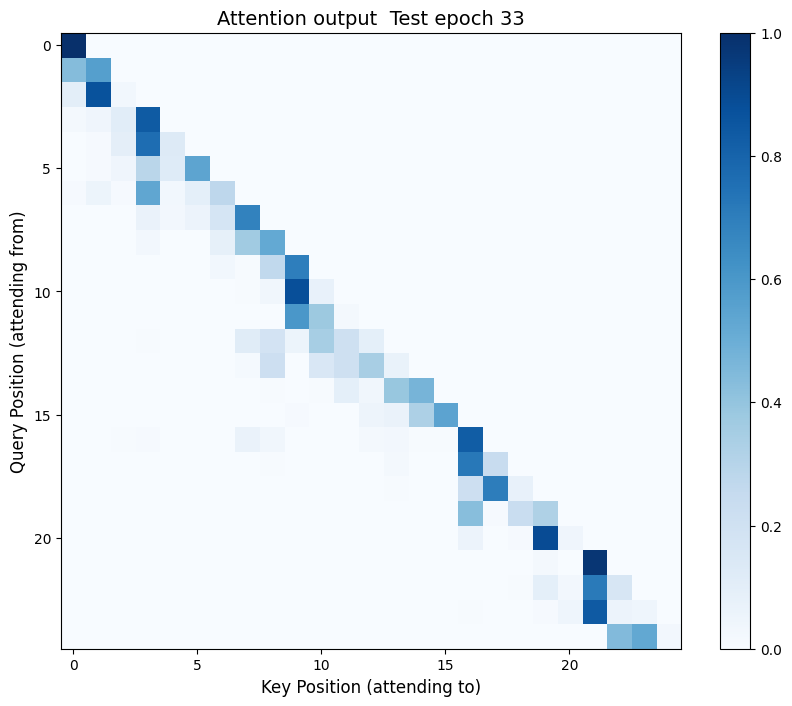

In [20]:
attention_plots[epoch]

In [21]:
attention_plots

{24: <Figure size 1000x800 with 2 Axes>,
 21: <Figure size 1000x800 with 2 Axes>,
 32: <Figure size 1000x800 with 2 Axes>}

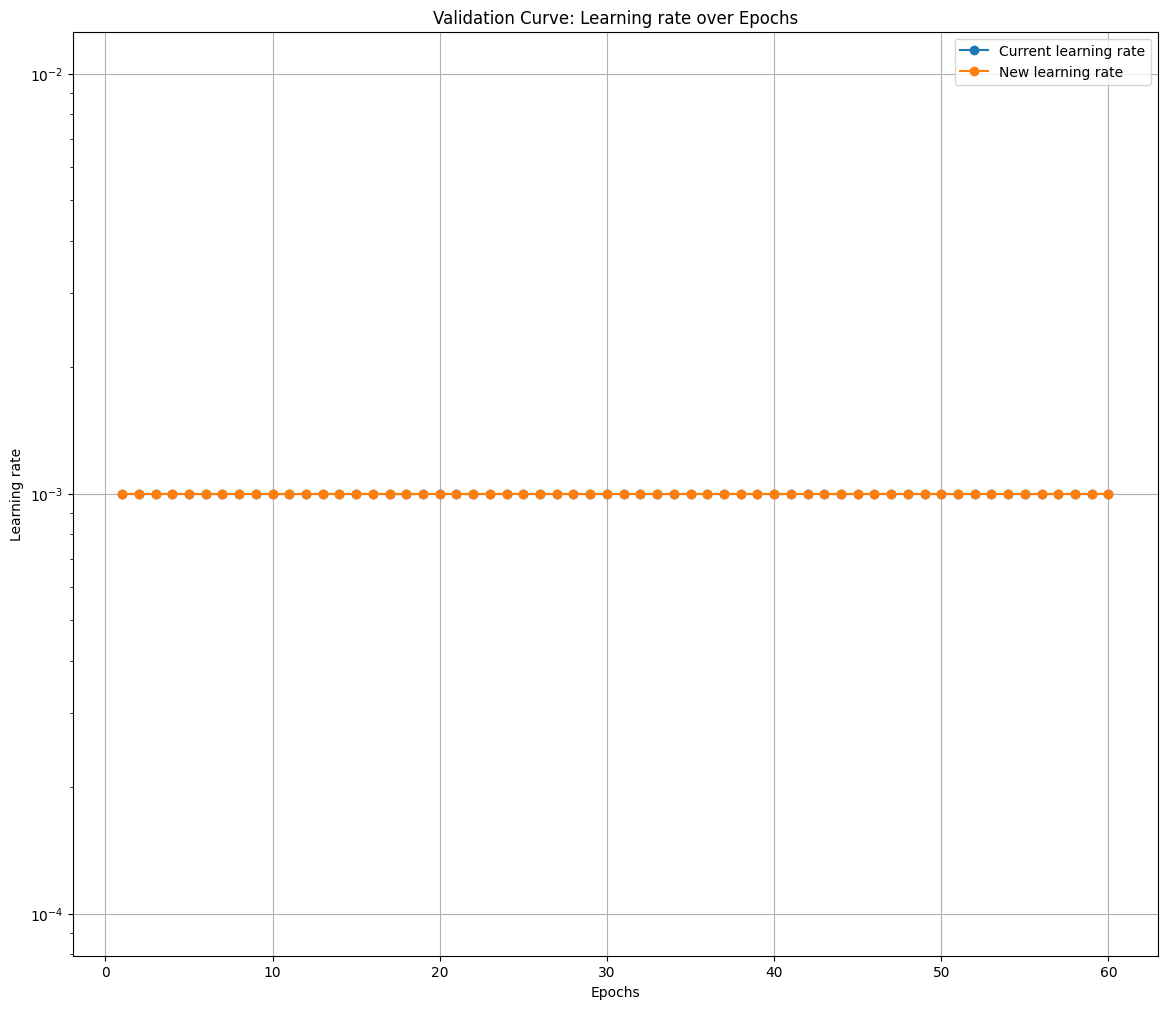

In [22]:
validation_plots[curve_type]

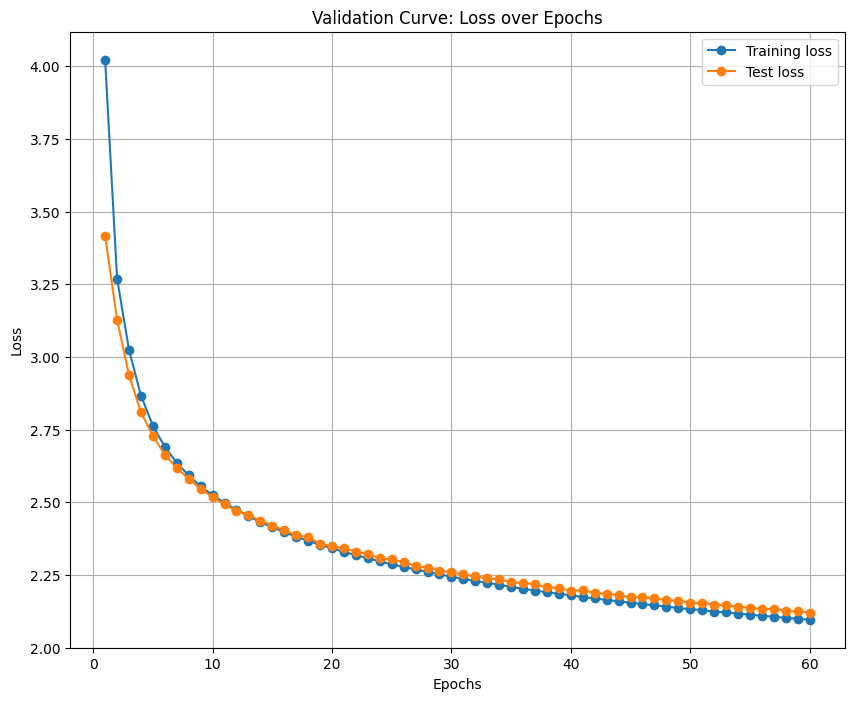

In [23]:
validation_plots['loss_curve']

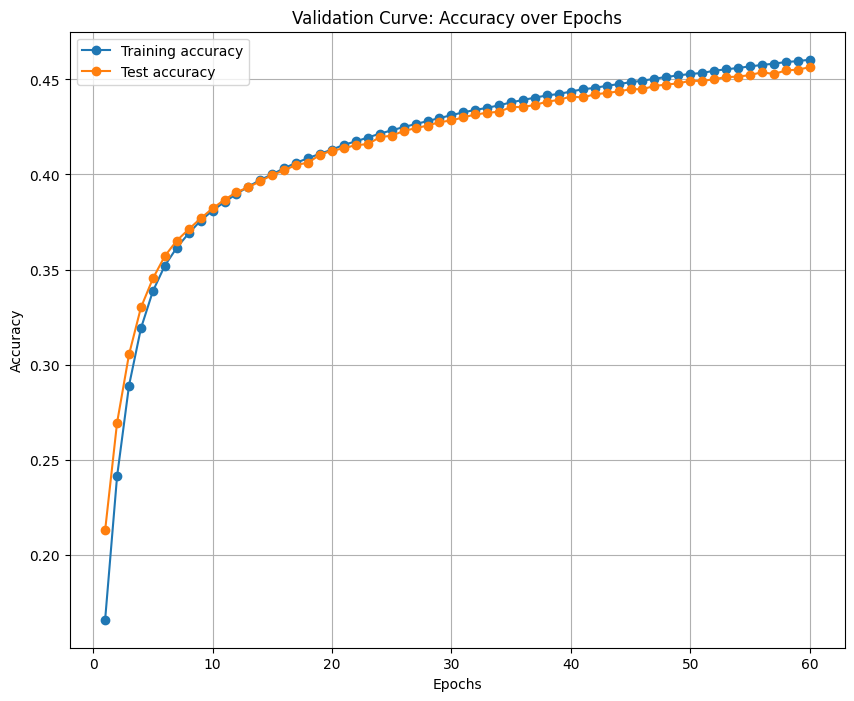

In [24]:
validation_plots['accuracy_curve']

### Save model results

In [25]:
# Create dfs for export

loss_table = pd.DataFrame({"Epoch": tt_epochs, "Train_loss":train_losses, "Test_loss":test_losses})
accuracy_table = pd.DataFrame({"Epoch": tt_epochs, "Train_accuracy":train_accs, "Test_accuracy":test_accs})
perplexity_table = pd.DataFrame({"Epoch": tt_epochs, "Train_perplexity":train_ppls, "Test_perplexity":test_ppls})
best_info = pd.DataFrame({"Best_epoch":[best_epoch], "Best_perplexity":[best_ppl]})

In [26]:
# Create attention table for test attentions

rows = []

for epoch_idx, all_attn in enumerate(test_attns):
    for layer_idx, attn in enumerate(all_attn):
        attn_matrix = attn[0].cpu().numpy()
        rows.append({
            "epoch": epoch_idx,
            "layer": layer_idx,
            "batch_idx": 0,
            "attention_matrix": attn_matrix
        })

attention_table = pd.DataFrame(rows)

In [27]:
full_metrics = pd.DataFrame()
full_metrics['Epoch'] = tt_epochs

for df in [loss_table, accuracy_table, perplexity_table]:
  full_metrics = pd.merge(full_metrics, df, on=['Epoch'], how='left', suffixes=('','_y'))
  print(full_metrics.columns)

Index(['Epoch', 'Train_loss', 'Test_loss'], dtype='object')
Index(['Epoch', 'Train_loss', 'Test_loss', 'Train_accuracy', 'Test_accuracy'], dtype='object')
Index(['Epoch', 'Train_loss', 'Test_loss', 'Train_accuracy', 'Test_accuracy',
       'Train_perplexity', 'Test_perplexity'],
      dtype='object')


In [28]:
train_lrs

,epoch,curr_lr,new_lr,loss,ppl,acc
0,1.0,0.001,0.001,4.022254,55.826786,0.165792
1,2.0,0.001,0.001,3.269639,26.301841,0.241173
2,3.0,0.001,0.001,3.024580,20.585353,0.288957
3,4.0,0.001,0.001,2.867082,17.585633,0.319102
4,5.0,0.001,0.001,2.763405,15.853725,0.338650
5,6.0,0.001,0.001,2.690695,14.741925,0.352055
6,7.0,0.001,0.001,2.635736,13.953575,0.361510
7,8.0,0.001,0.001,2.592258,13.359902,0.369059
8,9.0,0.001,0.001,2.554862,12.869528,0.375713
9,10.0,0.001,0.001,2.524850,12.489023,0.381018


In [29]:
# Save results for review

results_summary['full_metrics'] = full_metrics
results_summary['training_learning_rates'] = train_lrs
results_summary['attention_table'] = attention_table
results_summary['model_curves'] = best_info

In [30]:
# Output results to excel for easier review

with pd.ExcelWriter(path+result_filename) as writer:
    for sheet_name, result_df in results_summary.items():
        result_df.to_excel(writer, sheet_name = sheet_name, index=False)

    workbook = writer.book
    worksheet_attn = writer.sheets['attention_table']
    worksheet_validation = writer.sheets['model_curves']

    row = 0

    # Add validation curves
    for plot_name, fig in validation_plots.items():
        # Set the figure size
        fig.set_size_inches(8, 6)
        # Save the figure to a temporary file
        img_path = path+"plots/" + str(plot_name) + '.png'
        fig.savefig(img_path, bbox_inches='tight')
        # Insert the image into the worksheet
        worksheet_validation.insert_image(row, 6, img_path)
        plt.close(fig)  # Close the figure to free memory
        row += 30

    # Reset row count for new sheet
    row = 0

    for plot_name, fig in attention_plots.items():
          # Set the figure size
          fig.set_size_inches(8, 6)
          # Save the figure to a temporary file
          img_path = path + "plots/"  + str(plot_name) + '.png'
          fig.savefig(img_path, dpi=300, bbox_inches='tight')
          # Insert the image into the worksheet
          worksheet_attn.insert_image(row, 6, img_path)
          plt.close(fig)  # Close the figure to free memory
          row += 30

writer.close()

/usr/local/lib/python3.12/dist-packages/xlsxwriter/workbook.py:404: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")
